In [2]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
# Downloading data set in the "data" directory
dataset = MNIST(root='data/', download=True)

0.1%

31.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw


102.8%


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw




61.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
#Seeing the number of data in the data set
train_dataset = MNIST(root='data/', train=True)
test_dataset = MNIST(root='data/', train=False)
len(train_dataset),len(test_dataset)

(60000, 10000)

Label of 1000th data: 0


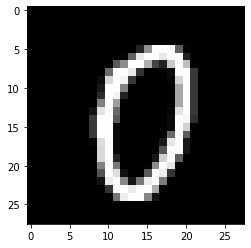

In [7]:
#Visualizing a data

%matplotlib inline

image, label = dataset[1000]
plt.imshow(image, cmap='gray')
print('Label of 1000th data:', label)

In [8]:
# Converting to Tensor
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [9]:
# Verifying the conversion to a Tensor
image_tensor, label = dataset[1000]
print(image_tensor.shape, label)

torch.Size([1, 28, 28]) 0


In [10]:
#Dividing the training set into Training and Validation sets
from torch.utils.data import random_split

train_data, validation_data = random_split(dataset, [50000, 10000])
len(train_data), len(validation_data)

(50000, 10000)

In [11]:
#creating a shufling process for traning process only

from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_data, batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size)

In [22]:
def Mykernel(image, kernel):
    Rowi, Columni = image.shape       # image dimensions
    Rowk, Columnk = kernel.shape      # kernel dimensions
    Rowo, Columno = Rowi-Rowk+1, Columni-Columnk+1  # output dimensions
    output = torch.zeros([Rowo, Columno])
    for i in range(Rowo): 
        for j in range(Columno):
            output[i,j] = torch.sum(image[i:i+Rowk,j:j+Columnk] * kernel)
    return output

In [25]:
class Classification(nn.Module):
    def training_function(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [28]:
class CNNModel1(Classification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 28, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(28, 56, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(56, 112, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(112, 112, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 112 x 7 x 7


            nn.Flatten(), 
            nn.Linear(112*7*7, 784),
            nn.ReLU(),
            nn.Linear(784, 392),
            nn.ReLU(),
            nn.Linear(392, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [29]:
model1 = CNNModel1()
model1

CNNModel1(
  (network): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(56, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=5488, out_features=784, bias=True)
    (12): ReLU()
    (13): Linear(in_features=784, out_features=392, bias=True)
    (14): ReLU()
    (15): Linear(in_features=392, out_features=10, bias=True)
  )
)

In [31]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model1(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 1, 28, 28])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0088, -0.0137, -0.0344, -0.0463,  0.0386, -0.0173, -0.0183,  0.0505,
         0.0025, -0.0418], grad_fn=<SelectBackward0>)


In [33]:
#Device choosing
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [34]:
device = get_default_device()
device

device(type='cpu')

In [36]:
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
to_device(model1, device);

In [43]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_function(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [44]:
model = to_device(CNNModel1(), device)

In [45]:
evaluate(model, validation_loader)

{'val_loss': 2.3023860454559326, 'val_acc': 0.10205696523189545}

In [46]:
#hyperparmeters
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [47]:
history = fit(num_epochs, lr, model, train_loader, validation_loader, opt_func)

Epoch [0], train_loss: 0.2509, val_loss: 0.0657, val_acc: 0.9809
Epoch [1], train_loss: 0.0464, val_loss: 0.0422, val_acc: 0.9867
Epoch [2], train_loss: 0.0291, val_loss: 0.0478, val_acc: 0.9868
Epoch [3], train_loss: 0.0215, val_loss: 0.0428, val_acc: 0.9867
Epoch [4], train_loss: 0.0161, val_loss: 0.0509, val_acc: 0.9864
Epoch [5], train_loss: 0.0137, val_loss: 0.0430, val_acc: 0.9890
Epoch [6], train_loss: 0.0115, val_loss: 0.0392, val_acc: 0.9907
Epoch [7], train_loss: 0.0102, val_loss: 0.0526, val_acc: 0.9869
Epoch [8], train_loss: 0.0103, val_loss: 0.0511, val_acc: 0.9902
Epoch [9], train_loss: 0.0074, val_loss: 0.0687, val_acc: 0.9854


In [56]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Model 1: Accuracy');

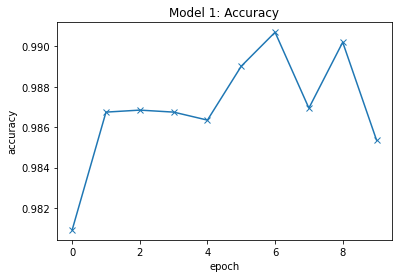

In [57]:
plot_accuracies(history)

In [58]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    plt.plot(train_losses, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('Train loss')
    plt.title('Model 1: Loss vs. No. of epochs');

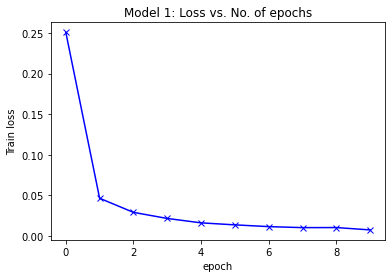

In [59]:
plot_losses(history)

In [79]:
class CNNModel2(Classification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 28, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(28, 112, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(112, 224, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(224, 224, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 224 x 7 x 7


            nn.Flatten(), 
            nn.Linear(224*7*7, 1568),
            nn.ReLU(),
            nn.Linear(1568, 784),
            nn.ReLU(),
            nn.Linear(784, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [66]:
model2 = CNNModel2()
model2

CNNModel2(
  (network): Sequential(
    (0): Conv2d(1, 28, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(28, 56, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(56, 112, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(112, 112, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=5488, out_features=784, bias=True)
    (12): ReLU()
    (13): Linear(in_features=784, out_features=392, bias=True)
    (14): ReLU()
    (15): Linear(in_features=392, out_features=10, bias=True)
  )
)

In [80]:
#Device choosing
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [81]:
device = get_default_device()
device

device(type='cpu')

In [82]:
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
to_device(model2, device);

In [83]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_function(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [84]:
model = to_device(CNNModel2(), device)

In [85]:
evaluate(model, validation_loader)

{'val_loss': 2.3025944232940674, 'val_acc': 0.10541930049657822}

In [86]:
#hyperparmeters
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [87]:
history = fit(num_epochs, lr, model, train_loader, validation_loader, opt_func)

Epoch [0], train_loss: 0.1907, val_loss: 0.0662, val_acc: 0.9821
Epoch [1], train_loss: 0.0453, val_loss: 0.0602, val_acc: 0.9831
Epoch [2], train_loss: 0.0301, val_loss: 0.0381, val_acc: 0.9876
Epoch [3], train_loss: 0.0221, val_loss: 0.0348, val_acc: 0.9900
Epoch [4], train_loss: 0.0183, val_loss: 0.0366, val_acc: 0.9899
Epoch [5], train_loss: 0.0136, val_loss: 0.0373, val_acc: 0.9905
Epoch [6], train_loss: 0.0130, val_loss: 0.0536, val_acc: 0.9874
Epoch [7], train_loss: 0.0128, val_loss: 0.0488, val_acc: 0.9873
Epoch [8], train_loss: 0.0120, val_loss: 0.0460, val_acc: 0.9889
Epoch [9], train_loss: 0.0085, val_loss: 0.0458, val_acc: 0.9905


In [88]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Model 2: Accuracy');

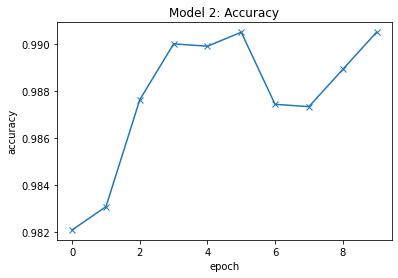

In [89]:
plot_accuracies(history)

In [90]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    plt.plot(train_losses, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('Train loss')
    plt.title('Model 2: Loss vs. No. of epochs');

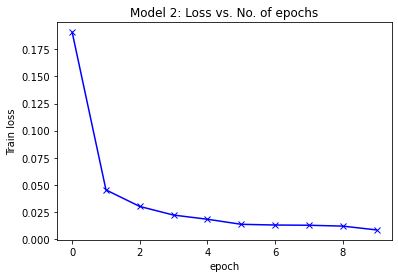

In [91]:
plot_losses(history)

In [92]:
class CNNModel3(Classification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 28, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(28, 28, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(28, 56, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(56, 56, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 56 x 7 x 7

            nn.Flatten(), 
            nn.Linear(56*7*7, 392),
            nn.ReLU(),
            nn.Linear(392, 196),
            nn.ReLU(),
            nn.Linear(196, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [93]:
model3 = CNNModel3()
model3

CNNModel3(
  (network): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=2744, out_features=392, bias=True)
    (12): ReLU()
    (13): Linear(in_features=392, out_features=196, bias=True)
    (14): ReLU()
    (15): Linear(in_features=196, out_features=10, bias=True)
  )
)

In [94]:
#Device choosing
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [95]:
device = get_default_device()
device

device(type='cpu')

In [97]:
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
to_device(model3, device);

In [98]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_function(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [99]:
model = to_device(CNNModel3(), device)

In [100]:
evaluate(model, validation_loader)

{'val_loss': 2.303454875946045, 'val_acc': 0.09988132864236832}

In [101]:
#hyperparmeters
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [102]:
history = fit(num_epochs, lr, model, train_loader, validation_loader, opt_func)

Epoch [0], train_loss: 0.2641, val_loss: 0.0786, val_acc: 0.9748
Epoch [1], train_loss: 0.0551, val_loss: 0.0548, val_acc: 0.9842
Epoch [2], train_loss: 0.0384, val_loss: 0.0422, val_acc: 0.9870
Epoch [3], train_loss: 0.0275, val_loss: 0.0499, val_acc: 0.9856
Epoch [4], train_loss: 0.0200, val_loss: 0.0499, val_acc: 0.9880
Epoch [5], train_loss: 0.0171, val_loss: 0.0431, val_acc: 0.9893
Epoch [6], train_loss: 0.0140, val_loss: 0.0403, val_acc: 0.9904
Epoch [7], train_loss: 0.0122, val_loss: 0.0429, val_acc: 0.9909
Epoch [8], train_loss: 0.0103, val_loss: 0.0475, val_acc: 0.9883
Epoch [9], train_loss: 0.0090, val_loss: 0.0500, val_acc: 0.9866


In [103]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Model 3: Accuracy');

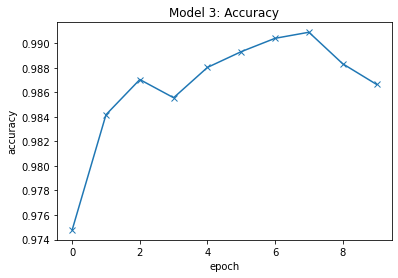

In [104]:
plot_accuracies(history)

In [105]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    plt.plot(train_losses, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('Train loss')
    plt.title('Model 3: Loss vs. No. of epochs');

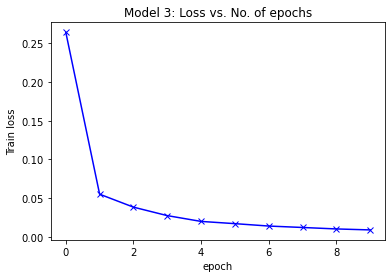

In [106]:
plot_losses(history)